## Neo4j Graph of TCGA Patients

In this notebook, we will build a graph in Neo4j with The Canger Genome Atlas Program (TCGA) patients, and cluster same-indication patients together based off of their expression profiles. These clusters can be correlated to biomarkers and relavant clinical features to find the main drivers of clustering. This same structure can be followed to add different data modalities, using their respective similarity metrics. In conjunction with other data modalities, we can discover novel-subtyping results to improve predicitve performance. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphdatascience import GraphDataScience
from scipy import stats
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import seaborn as sns
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival

In [2]:
# Load TPM counts of TCGA patients extracted from recount3 expression profiles (https://rna.recount.bio/docs/) 
tpm = pd.read_csv("tcga_output/tcga_tpm_matrix.csv", index_col = "Gene_ID")

In [3]:
# Normalize TPM using log2(TPM + 1) transformation
log2tpm = np.log2(tpm + 1.0)

log2tpm = log2tpm[log2tpm.mean(axis=1) > 1.0]
log2tpm.index = [x.split(".")[0] for x in log2tpm.index.values]
log2tpm = log2tpm.T

log2tpm

,ENSG00000278267,ENSG00000227232,ENSG00000268903,ENSG00000269981,ENSG00000273874,ENSG00000279457,ENSG00000241670,ENSG00000228463,ENSG00000250575,ENSG00000225972,...,ENSG00000237701,ENSG00000252155,ENSG00000114374,ENSG00000067048,ENSG00000215414,ENSG00000185275,ENSG00000131002,ENSG00000012817,ENSG00000198692,ENSG00000279274
43e715bf-28d9-4b5e-b762-8cd1b69a430e,2.817746,4.367172,1.881472,2.447603,1.787044,4.696636,2.981585,2.028666,1.367371,10.818561,...,3.892581,0.302109,0.000000,0.011027,4.412223,0.000000,0.000000,0.000000,0.000000,2.250885
1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,2.773079,4.281282,4.568715,4.671913,1.994498,5.024954,4.007073,1.843778,2.980633,10.380938,...,2.663028,0.882096,0.004668,0.027213,4.705727,1.777231,0.013789,0.004966,0.022660,3.103081
93b382e4-9c9a-43f5-bd3b-502cc260b886,2.277732,4.434586,2.101864,2.740833,2.123758,5.151980,3.313672,1.562713,2.514150,9.683042,...,4.222405,0.000000,0.000000,0.000000,4.767333,0.000000,0.000000,0.000000,0.000000,2.967610
1f39dadd-3655-474e-ba4c-a5bd32c97a8b,3.332908,7.608742,0.624856,2.244079,2.948350,8.272222,5.938327,6.630389,1.281656,9.715813,...,3.663869,0.000000,0.000000,0.000000,4.942634,0.162284,0.000000,0.000000,0.000000,1.981617
8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,1.847950,3.595816,2.178801,2.679502,1.269354,4.054402,2.632549,1.080808,1.300599,11.775976,...,2.195553,0.150023,0.002341,0.000000,3.851865,0.365328,0.000000,0.000000,0.000000,2.626374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3ee533bd-5832-4007-8f1f-439166256eb0,1.791355,4.091908,0.387308,2.024720,0.909475,4.763692,1.941344,0.670707,1.503142,9.969082,...,2.413921,0.925897,0.000000,0.006856,3.475774,0.000000,0.000000,0.004777,0.000000,3.600132
a2c71c07-af0c-4016-808c-dfef458c91c7,2.616742,4.195820,0.258405,2.195801,2.571694,4.858655,2.562833,1.436903,1.028432,9.781007,...,3.465425,0.358365,0.059304,0.451053,5.244554,0.000000,0.057652,0.218740,0.249938,3.833726
98b2a7f8-a7bd-4da2-8541-950e44d9acd7,0.673769,3.055841,0.040186,1.060047,0.386500,3.842909,1.778780,0.474716,0.713093,12.180643,...,2.381002,0.000000,0.000000,0.010358,2.048596,0.000000,0.005289,0.000000,0.014720,2.815767
d3fc3968-b263-4756-bf7f-1941f70b04da,0.669456,2.476907,0.000000,0.712956,0.600902,3.905182,1.697818,0.538155,0.377500,10.941727,...,2.253041,0.000000,0.050651,0.585698,3.965862,0.000000,0.027319,0.245874,0.203039,3.470232


In [4]:
# Load meta data containing TCGA barcodes for each sample and the indication the sample belongs to
meta = pd.read_csv("tcga_output/tcga_metadata.csv", low_memory=False)

In [5]:
meta

,Sample_ID,rail_id,external_id,study,tcga.tcga_barcode,tcga.gdc_file_id,tcga.gdc_cases.project.name,tcga.gdc_cases.project.released,tcga.gdc_cases.project.state,tcga.gdc_cases.project.primary_site,...,recount_seq_qc..distinct_quality_values,recount_seq_qc..bases,recount_seq_qc..a,recount_seq_qc..c,recount_seq_qc..g,recount_seq_qc..t,recount_seq_qc..n,recount_seq_qc.avgq,recount_seq_qc.errq,BigWigURL
0,43e715bf-28d9-4b5e-b762-8cd1b69a430e,106797,43e715bf-28d9-4b5e-b762-8cd1b69a430e,ACC,TCGA-OR-A5KU-01A-11R-A29S-07,43e715bf-28d9-4b5e-b762-8cd1b69a430e,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,1940669424,25.0,25.2,23.7,26.0,0.1,34.8,20.7,http://duffel.rail.bio/recount3/human/data_sou...
1,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,110230,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,ACC,TCGA-P6-A5OG-01A-22R-A29S-07,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3129297696,25.0,25.1,24.6,25.2,0.0,37.0,24.1,http://duffel.rail.bio/recount3/human/data_sou...
2,93b382e4-9c9a-43f5-bd3b-502cc260b886,110773,93b382e4-9c9a-43f5-bd3b-502cc260b886,ACC,TCGA-OR-A5K5-01A-11R-A29S-07,93b382e4-9c9a-43f5-bd3b-502cc260b886,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3002229744,24.2,26.0,24.7,25.0,0.1,34.1,19.8,http://duffel.rail.bio/recount3/human/data_sou...
3,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,110869,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,ACC,TCGA-OR-A5K4-01A-11R-A29S-07,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,2259320928,24.3,25.7,24.5,25.5,0.1,34.4,20.0,http://duffel.rail.bio/recount3/human/data_sou...
4,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,116503,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,ACC,TCGA-OR-A5LP-01A-11R-A29S-07,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3708909120,25.0,25.1,24.6,25.3,0.0,37.3,24.8,http://duffel.rail.bio/recount3/human/data_sou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,3ee533bd-5832-4007-8f1f-439166256eb0,926755,3ee533bd-5832-4007-8f1f-439166256eb0,UVM,TCGA-VD-A8KB-01A-11R-A405-07,3ee533bd-5832-4007-8f1f-439166256eb0,Uveal Melanoma,True,legacy,Eye,...,38,3008686512,23.6,26.5,26.0,23.8,0.0,37.4,25.0,http://duffel.rail.bio/recount3/human/data_sou...
10755,a2c71c07-af0c-4016-808c-dfef458c91c7,931298,a2c71c07-af0c-4016-808c-dfef458c91c7,UVM,TCGA-V4-A9EI-01A-11R-A405-07,a2c71c07-af0c-4016-808c-dfef458c91c7,Uveal Melanoma,True,legacy,Eye,...,38,3858772224,24.4,25.9,25.2,24.5,0.0,36.6,23.3,http://duffel.rail.bio/recount3/human/data_sou...
10756,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,935394,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,UVM,TCGA-V4-A9EY-01A-11R-A405-07,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,Uveal Melanoma,True,legacy,Eye,...,38,2028253968,24.3,26.8,25.7,23.3,0.0,36.5,23.0,http://duffel.rail.bio/recount3/human/data_sou...
10757,d3fc3968-b263-4756-bf7f-1941f70b04da,936046,d3fc3968-b263-4756-bf7f-1941f70b04da,UVM,TCGA-VD-AA8N-01A-11R-A405-07,d3fc3968-b263-4756-bf7f-1941f70b04da,Uveal Melanoma,True,legacy,Eye,...,38,1498262112,25.2,26.4,24.5,23.9,0.0,38.6,27.0,http://duffel.rail.bio/recount3/human/data_sou...


In [6]:
# Only consider samples from primary tumor
discardSamples = meta[meta["tcga.cgc_sample_sample_type"] != "Primary Tumor"]
meta = meta.drop(discardSamples.index)
log2tpm = log2tpm.drop(discardSamples["Sample_ID"])   
meta

,Sample_ID,rail_id,external_id,study,tcga.tcga_barcode,tcga.gdc_file_id,tcga.gdc_cases.project.name,tcga.gdc_cases.project.released,tcga.gdc_cases.project.state,tcga.gdc_cases.project.primary_site,...,recount_seq_qc..distinct_quality_values,recount_seq_qc..bases,recount_seq_qc..a,recount_seq_qc..c,recount_seq_qc..g,recount_seq_qc..t,recount_seq_qc..n,recount_seq_qc.avgq,recount_seq_qc.errq,BigWigURL
0,43e715bf-28d9-4b5e-b762-8cd1b69a430e,106797,43e715bf-28d9-4b5e-b762-8cd1b69a430e,ACC,TCGA-OR-A5KU-01A-11R-A29S-07,43e715bf-28d9-4b5e-b762-8cd1b69a430e,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,1940669424,25.0,25.2,23.7,26.0,0.1,34.8,20.7,http://duffel.rail.bio/recount3/human/data_sou...
1,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,110230,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,ACC,TCGA-P6-A5OG-01A-22R-A29S-07,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3129297696,25.0,25.1,24.6,25.2,0.0,37.0,24.1,http://duffel.rail.bio/recount3/human/data_sou...
2,93b382e4-9c9a-43f5-bd3b-502cc260b886,110773,93b382e4-9c9a-43f5-bd3b-502cc260b886,ACC,TCGA-OR-A5K5-01A-11R-A29S-07,93b382e4-9c9a-43f5-bd3b-502cc260b886,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3002229744,24.2,26.0,24.7,25.0,0.1,34.1,19.8,http://duffel.rail.bio/recount3/human/data_sou...
3,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,110869,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,ACC,TCGA-OR-A5K4-01A-11R-A29S-07,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,2259320928,24.3,25.7,24.5,25.5,0.1,34.4,20.0,http://duffel.rail.bio/recount3/human/data_sou...
4,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,116503,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,ACC,TCGA-OR-A5LP-01A-11R-A29S-07,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3708909120,25.0,25.1,24.6,25.3,0.0,37.3,24.8,http://duffel.rail.bio/recount3/human/data_sou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,3ee533bd-5832-4007-8f1f-439166256eb0,926755,3ee533bd-5832-4007-8f1f-439166256eb0,UVM,TCGA-VD-A8KB-01A-11R-A405-07,3ee533bd-5832-4007-8f1f-439166256eb0,Uveal Melanoma,True,legacy,Eye,...,38,3008686512,23.6,26.5,26.0,23.8,0.0,37.4,25.0,http://duffel.rail.bio/recount3/human/data_sou...
10755,a2c71c07-af0c-4016-808c-dfef458c91c7,931298,a2c71c07-af0c-4016-808c-dfef458c91c7,UVM,TCGA-V4-A9EI-01A-11R-A405-07,a2c71c07-af0c-4016-808c-dfef458c91c7,Uveal Melanoma,True,legacy,Eye,...,38,3858772224,24.4,25.9,25.2,24.5,0.0,36.6,23.3,http://duffel.rail.bio/recount3/human/data_sou...
10756,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,935394,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,UVM,TCGA-V4-A9EY-01A-11R-A405-07,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,Uveal Melanoma,True,legacy,Eye,...,38,2028253968,24.3,26.8,25.7,23.3,0.0,36.5,23.0,http://duffel.rail.bio/recount3/human/data_sou...
10757,d3fc3968-b263-4756-bf7f-1941f70b04da,936046,d3fc3968-b263-4756-bf7f-1941f70b04da,UVM,TCGA-VD-AA8N-01A-11R-A405-07,d3fc3968-b263-4756-bf7f-1941f70b04da,Uveal Melanoma,True,legacy,Eye,...,38,1498262112,25.2,26.4,24.5,23.9,0.0,38.6,27.0,http://duffel.rail.bio/recount3/human/data_sou...


In [7]:
# Add TCGA barcodes to each sample down to the patient level in log2tpm and meta data
barcodes = meta.copy()
barcodes = barcodes[["Sample_ID", "tcga.tcga_barcode"]]
barcodes["tcga_patient"] = ["-".join(x.split("-")[:3]) for x in barcodes["tcga.tcga_barcode"]]
barcodes = barcodes.drop(columns = ["tcga.tcga_barcode"])
barcodes = barcodes.set_index("Sample_ID")

meta["tcga_patient"] = ["-".join(x.split("-")[:3]) for x in meta["tcga.tcga_barcode"]]
meta.drop_duplicates(inplace = True)
meta.set_index("tcga_patient", inplace = True)
meta = meta.loc[~meta.index.duplicated(keep='first')]
meta

,Sample_ID,rail_id,external_id,study,tcga.tcga_barcode,tcga.gdc_file_id,tcga.gdc_cases.project.name,tcga.gdc_cases.project.released,tcga.gdc_cases.project.state,tcga.gdc_cases.project.primary_site,...,recount_seq_qc..distinct_quality_values,recount_seq_qc..bases,recount_seq_qc..a,recount_seq_qc..c,recount_seq_qc..g,recount_seq_qc..t,recount_seq_qc..n,recount_seq_qc.avgq,recount_seq_qc.errq,BigWigURL
tcga_patient,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5KU,43e715bf-28d9-4b5e-b762-8cd1b69a430e,106797,43e715bf-28d9-4b5e-b762-8cd1b69a430e,ACC,TCGA-OR-A5KU-01A-11R-A29S-07,43e715bf-28d9-4b5e-b762-8cd1b69a430e,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,1940669424,25.0,25.2,23.7,26.0,0.1,34.8,20.7,http://duffel.rail.bio/recount3/human/data_sou...
TCGA-P6-A5OG,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,110230,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,ACC,TCGA-P6-A5OG-01A-22R-A29S-07,1a5db9fc-2abd-4e1b-b5ef-b1cf5e5f3872,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3129297696,25.0,25.1,24.6,25.2,0.0,37.0,24.1,http://duffel.rail.bio/recount3/human/data_sou...
TCGA-OR-A5K5,93b382e4-9c9a-43f5-bd3b-502cc260b886,110773,93b382e4-9c9a-43f5-bd3b-502cc260b886,ACC,TCGA-OR-A5K5-01A-11R-A29S-07,93b382e4-9c9a-43f5-bd3b-502cc260b886,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3002229744,24.2,26.0,24.7,25.0,0.1,34.1,19.8,http://duffel.rail.bio/recount3/human/data_sou...
TCGA-OR-A5K4,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,110869,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,ACC,TCGA-OR-A5K4-01A-11R-A29S-07,1f39dadd-3655-474e-ba4c-a5bd32c97a8b,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,2259320928,24.3,25.7,24.5,25.5,0.1,34.4,20.0,http://duffel.rail.bio/recount3/human/data_sou...
TCGA-OR-A5LP,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,116503,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,ACC,TCGA-OR-A5LP-01A-11R-A29S-07,8c8c09b9-ec83-45ec-bc4c-0ba92de60acb,Adrenocortical Carcinoma,True,legacy,Adrenal Gland,...,38,3708909120,25.0,25.1,24.6,25.3,0.0,37.3,24.8,http://duffel.rail.bio/recount3/human/data_sou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-VD-A8KB,3ee533bd-5832-4007-8f1f-439166256eb0,926755,3ee533bd-5832-4007-8f1f-439166256eb0,UVM,TCGA-VD-A8KB-01A-11R-A405-07,3ee533bd-5832-4007-8f1f-439166256eb0,Uveal Melanoma,True,legacy,Eye,...,38,3008686512,23.6,26.5,26.0,23.8,0.0,37.4,25.0,http://duffel.rail.bio/recount3/human/data_sou...
TCGA-V4-A9EI,a2c71c07-af0c-4016-808c-dfef458c91c7,931298,a2c71c07-af0c-4016-808c-dfef458c91c7,UVM,TCGA-V4-A9EI-01A-11R-A405-07,a2c71c07-af0c-4016-808c-dfef458c91c7,Uveal Melanoma,True,legacy,Eye,...,38,3858772224,24.4,25.9,25.2,24.5,0.0,36.6,23.3,http://duffel.rail.bio/recount3/human/data_sou...
TCGA-V4-A9EY,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,935394,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,UVM,TCGA-V4-A9EY-01A-11R-A405-07,98b2a7f8-a7bd-4da2-8541-950e44d9acd7,Uveal Melanoma,True,legacy,Eye,...,38,2028253968,24.3,26.8,25.7,23.3,0.0,36.5,23.0,http://duffel.rail.bio/recount3/human/data_sou...


In [8]:
# Set index of log2tpm to patient TCGA barcodes
patients = []
for sample in barcodes.index:
    patient = barcodes.loc[sample, "tcga_patient"]
    patients.append(patient)
log2tpm.index = patients

# Remove duplicated samples as result of abridging TCGA barcode
log2tpm = log2tpm.loc[~log2tpm.index.duplicated(keep='first')]
log2tpm

,ENSG00000278267,ENSG00000227232,ENSG00000268903,ENSG00000269981,ENSG00000273874,ENSG00000279457,ENSG00000241670,ENSG00000228463,ENSG00000250575,ENSG00000225972,...,ENSG00000237701,ENSG00000252155,ENSG00000114374,ENSG00000067048,ENSG00000215414,ENSG00000185275,ENSG00000131002,ENSG00000012817,ENSG00000198692,ENSG00000279274
TCGA-OR-A5KU,2.817746,4.367172,1.881472,2.447603,1.787044,4.696636,2.981585,2.028666,1.367371,10.818561,...,3.892581,0.302109,0.000000,0.011027,4.412223,0.000000,0.000000,0.000000,0.000000,2.250885
TCGA-P6-A5OG,2.773079,4.281282,4.568715,4.671913,1.994498,5.024954,4.007073,1.843778,2.980633,10.380938,...,2.663028,0.882096,0.004668,0.027213,4.705727,1.777231,0.013789,0.004966,0.022660,3.103081
TCGA-OR-A5K5,2.277732,4.434586,2.101864,2.740833,2.123758,5.151980,3.313672,1.562713,2.514150,9.683042,...,4.222405,0.000000,0.000000,0.000000,4.767333,0.000000,0.000000,0.000000,0.000000,2.967610
TCGA-OR-A5K4,3.332908,7.608742,0.624856,2.244079,2.948350,8.272222,5.938327,6.630389,1.281656,9.715813,...,3.663869,0.000000,0.000000,0.000000,4.942634,0.162284,0.000000,0.000000,0.000000,1.981617
TCGA-OR-A5LP,1.847950,3.595816,2.178801,2.679502,1.269354,4.054402,2.632549,1.080808,1.300599,11.775976,...,2.195553,0.150023,0.002341,0.000000,3.851865,0.365328,0.000000,0.000000,0.000000,2.626374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-VD-A8KB,1.791355,4.091908,0.387308,2.024720,0.909475,4.763692,1.941344,0.670707,1.503142,9.969082,...,2.413921,0.925897,0.000000,0.006856,3.475774,0.000000,0.000000,0.004777,0.000000,3.600132
TCGA-V4-A9EI,2.616742,4.195820,0.258405,2.195801,2.571694,4.858655,2.562833,1.436903,1.028432,9.781007,...,3.465425,0.358365,0.059304,0.451053,5.244554,0.000000,0.057652,0.218740,0.249938,3.833726
TCGA-V4-A9EY,0.673769,3.055841,0.040186,1.060047,0.386500,3.842909,1.778780,0.474716,0.713093,12.180643,...,2.381002,0.000000,0.000000,0.010358,2.048596,0.000000,0.005289,0.000000,0.014720,2.815767
TCGA-VD-AA8N,0.669456,2.476907,0.000000,0.712956,0.600902,3.905182,1.697818,0.538155,0.377500,10.941727,...,2.253041,0.000000,0.050651,0.585698,3.965862,0.000000,0.027319,0.245874,0.203039,3.470232


In [9]:
# Calculate spearman correlation coefficients between every sample
spearman, p_values = stats.spearmanr(log2tpm, axis = 1)

# Set correlation coefficients between same samples to 0 to omit during nearest-neighbors analysis
np.fill_diagonal(spearman, 0)

spearman = pd.DataFrame(spearman, columns = log2tpm.index, index = log2tpm.index) 
spearman

,TCGA-OR-A5KU,TCGA-P6-A5OG,TCGA-OR-A5K5,TCGA-OR-A5K4,TCGA-OR-A5LP,TCGA-PK-A5H9,TCGA-OR-A5LD,TCGA-OR-A5JX,TCGA-PK-A5H8,TCGA-OR-A5J3,...,TCGA-WC-A884,TCGA-V4-A9F5,TCGA-VD-A8K8,TCGA-V4-A9EV,TCGA-VD-A8K7,TCGA-VD-A8KB,TCGA-V4-A9EI,TCGA-V4-A9EY,TCGA-VD-AA8N,TCGA-V4-A9ET
TCGA-OR-A5KU,0.000000,0.714343,0.866798,0.858282,0.860050,0.769873,0.793449,0.891842,0.854085,0.893570,...,0.738155,0.751290,0.750805,0.732468,0.725735,0.718373,0.758926,0.680887,0.722886,0.702400
TCGA-P6-A5OG,0.714343,0.000000,0.755243,0.702260,0.759574,0.704137,0.714308,0.743540,0.732279,0.716155,...,0.761006,0.735766,0.766765,0.785183,0.695817,0.702623,0.766029,0.679492,0.767198,0.699480
TCGA-OR-A5K5,0.866798,0.755243,0.000000,0.820140,0.804100,0.745992,0.827720,0.838591,0.828709,0.852031,...,0.767768,0.782849,0.771215,0.744318,0.741235,0.754439,0.782940,0.725807,0.763668,0.747793
TCGA-OR-A5K4,0.858282,0.702260,0.820140,0.000000,0.860556,0.815159,0.783521,0.825237,0.882324,0.842337,...,0.732652,0.754010,0.767736,0.743005,0.751267,0.742857,0.775123,0.678586,0.722667,0.718846
TCGA-OR-A5LP,0.860050,0.759574,0.804100,0.860556,0.000000,0.831140,0.727216,0.830744,0.857778,0.867802,...,0.766869,0.737710,0.774565,0.773081,0.740386,0.719350,0.767029,0.692761,0.746629,0.706212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-VD-A8KB,0.718373,0.702623,0.754439,0.742857,0.719350,0.700627,0.715368,0.727114,0.730371,0.736527,...,0.907733,0.925601,0.902999,0.864748,0.914745,0.000000,0.898077,0.901662,0.904519,0.964831
TCGA-V4-A9EI,0.758926,0.766029,0.782940,0.775123,0.767029,0.738512,0.727976,0.747839,0.759501,0.768050,...,0.885533,0.937397,0.955206,0.927759,0.871791,0.898077,0.000000,0.834838,0.929170,0.884717
TCGA-V4-A9EY,0.680887,0.679492,0.725807,0.678586,0.692761,0.650575,0.670426,0.699239,0.672815,0.701982,...,0.926721,0.894093,0.856571,0.827156,0.800215,0.901662,0.834838,0.000000,0.905695,0.924450
TCGA-VD-AA8N,0.722886,0.767198,0.763668,0.722667,0.746629,0.697531,0.712020,0.735727,0.721722,0.740257,...,0.931316,0.945582,0.935368,0.920614,0.830252,0.904519,0.929170,0.905695,0.000000,0.915471


In [10]:
# Neighbors function to help generate k-Nearest Neighbors list to build Neo4j graph
# Return list of tuples containing the neighbor and spearman correlation coefficient for a given sample
# A sample can only be a neighbor with another sample if they are within the same indication
def get_neighbors(sample, spearman, meta):
    neighbors = []
    sample_study = meta.loc[sample, "study"]
    for neighbor in spearman.columns:
        if neighbor == sample:
            continue
        neighbor_study = meta.loc[neighbor, "study"]
        if neighbor_study != sample_study:
            continue
        neighbors.append((spearman[sample][neighbor], neighbor))
    return neighbors

In [11]:
# Computes the k-Nearest Neighbors for every patient from the spearman's rank analysis
k = 5

nearest_neighbors = pd.DataFrame(columns=["sample", "neighbor", "study"])
index = 0

for sample in spearman:
    neighbors = get_neighbors(sample, spearman, meta)
    neighbors.sort(reverse = True)
    k_neighbors = [neighbor for spearman, neighbor in neighbors[:k]]

    for neighbor in k_neighbors:
        if neighbor < sample: 
            nearest_neighbors.loc[index] = [neighbor, sample, meta.loc[sample, "study"]]
        else:
            nearest_neighbors.loc[index] = [sample, neighbor, meta.loc[sample, "study"]]
        index += 1

nearest_neighbors

,sample,neighbor,study
0,TCGA-OR-A5JF,TCGA-OR-A5KU,ACC
1,TCGA-OR-A5JC,TCGA-OR-A5KU,ACC
2,TCGA-OR-A5KU,TCGA-P6-A5OF,ACC
3,TCGA-OR-A5KU,TCGA-OR-A5LM,ACC
4,TCGA-OR-A5J3,TCGA-OR-A5KU,ACC
...,...,...,...
46365,TCGA-V4-A9ET,TCGA-VD-A8KB,UVM
46366,TCGA-V4-A9E9,TCGA-V4-A9ET,UVM
46367,TCGA-V4-A9ET,TCGA-WC-A885,UVM
46368,TCGA-V4-A9ET,TCGA-VD-AA8S,UVM


In [12]:
# Removes duplicate neighbor-relationships since relationships are undirected in actuality 
nearest_neighbors.drop_duplicates(keep = "first", inplace = True)
nearest_neighbors

,sample,neighbor,study
0,TCGA-OR-A5JF,TCGA-OR-A5KU,ACC
1,TCGA-OR-A5JC,TCGA-OR-A5KU,ACC
2,TCGA-OR-A5KU,TCGA-P6-A5OF,ACC
3,TCGA-OR-A5KU,TCGA-OR-A5LM,ACC
4,TCGA-OR-A5J3,TCGA-OR-A5KU,ACC
...,...,...,...
46356,TCGA-V4-A9EY,TCGA-VD-AA8M,UVM
46358,TCGA-V4-A9EY,TCGA-VD-AA8S,UVM
46363,TCGA-VD-A8KN,TCGA-VD-AA8N,UVM
46364,TCGA-V4-A9EQ,TCGA-VD-AA8N,UVM


In [13]:
# Create connection to Neo4j database through python driver
# URI could look similar to "bolt://my-server.neo4j.io:7687"

URI = "bolt://localhost:7687"
user = "neo4j"
password = "cluster123"
gds = GraphDataScience(URI, auth=(user, password), database = "neo4j")

# Check the installed GDS version on the server
print(gds.version())
assert gds.version()

2.9.0


In [16]:
# Uncomment to delete all nodes and relationships from database
gds.run_cypher("MATCH (n) DETACH DELETE n")

# Iterates through neighbors list to create nodes for every sample and neighbor, and an `EXPRESSION_NEIGHBOR` relationship between the two nodes
for sample, neighbor, study in tqdm(nearest_neighbors.values.tolist()):
    gds.run_cypher(f"MERGE (:{study} {{name: '{sample}'}})")
    
    gds.run_cypher(f"MERGE (:{study} {{name: '{neighbor}'}})")

    gds.run_cypher(f"MATCH (s:{study} {{name: '{sample}'}}) MATCH (n:{study} {{name: '{neighbor}'}}) MERGE (s)-[:EXPRESSION_NEIGHBOR]-(n)")

# Returns stats about how many nodes and relationships are currently in database
gds.run_cypher("""CALL apoc.meta.stats() 
                YIELD nodeCount, relCount 
                RETURN nodeCount AS `Number of Nodes`, relCount AS `Number of Relationships`""")
    

  0%|          | 0/38127 [00:00<?, ?it/s]

,Number of Nodes,Number of Relationships
0,9274,38127


In [17]:
# Create in-memory graph projection of whole graph
gds.run_cypher("""
    CALL db.labels() YIELD label
    WITH collect(label) AS allLabels
    CALL gds.graph.project("wholeGraph",
        allLabels,
        {
        EXPRESSION_NEIGHBOR: 
            {orientation: "UNDIRECTED"}
        }
    )
    YIELD graphName, nodeCount, relationshipCount
    RETURN graphName AS `graph name`, nodeCount AS `number of nodes`, relationshipCount AS `number of relationships`
"""
)

,graph name,number of nodes,number of relationships
0,wholeGraph,9274,76254


In [18]:
# Filter 'wholeGraph' graph projection to only include LUAD patients
gds.run_cypher("""
    CALL gds.graph.filter("LUAD",
        "wholeGraph", 
        "n:LUAD",
        "*"
    )
    YIELD graphName, nodeCount, relationshipCount
    RETURN graphName AS `graph name`, nodeCount AS `number of nodes`, relationshipCount AS `number of relationships`
"""
)

,graph name,number of nodes,number of relationships
0,LUAD,516,4350


In [19]:
# Perform leiden clustering on LUAD patients
gds.run_cypher(""" 
    CALL gds.leiden.write('LUAD', { writeProperty: 'leidenID'})
    YIELD communityCount, nodePropertiesWritten, modularity
    RETURN communityCount AS `number of clusters`, nodePropertiesWritten AS `number of nodes updated`, modularity
"""
)

,number of clusters,number of nodes updated,modularity
0,11,516,0.621168


In [20]:
# Generate vector embeddings for each LUAD patient node using Neo4j's built in Fast Random Projection algorithm
gds.run_cypher("""
    CALL gds.fastRP.write(
      'LUAD',
      {
        embeddingDimension: 128,
        writeProperty: 'embedding'
      }
    )
    YIELD nodePropertiesWritten 
    RETURN nodePropertiesWritten AS `number of embeddings written`
"""
)

,number of embeddings written
0,516


In [21]:
# Export embeddings and clustering results
nodes = gds.run_cypher("""
    MATCH (n:LUAD)
    RETURN n.name AS patient, n.leidenID AS cluster, n.embedding AS embedding
"""
)

nodes

,patient,cluster,embedding
0,TCGA-55-7903,8,"[-0.04915890097618103, -0.14553982019424438, -..."
1,TCGA-55-7911,8,"[-0.10209953784942627, -0.13221874833106995, 0..."
2,TCGA-95-A4VN,8,"[-0.08148293197154999, -0.08444379270076752, -..."
3,TCGA-MP-A4SV,8,"[-0.015763623639941216, -0.10628969222307205, ..."
4,TCGA-62-A46Y,8,"[-0.013730181381106377, 0.014249728992581367, ..."
...,...,...,...
511,TCGA-55-A490,3,"[-0.008565259166061878, -0.16462650895118713, ..."
512,TCGA-95-7944,4,"[0.1789611577987671, -0.06177249550819397, -0...."
513,TCGA-86-6851,0,"[-0.0300060473382473, -0.005298994481563568, -..."
514,TCGA-62-8399,3,"[-0.0582629069685936, -0.04219527542591095, -0..."


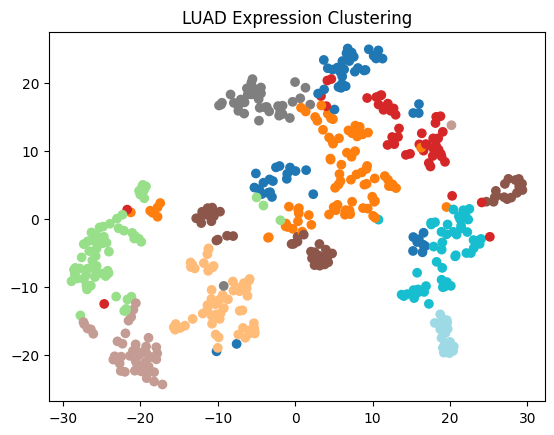

In [22]:
# Visualize clustering results through a TSNE dimensionality reduction
nodes['cluster'] = pd.Categorical(nodes.cluster)

#embedding = nodes.embedding.apply(lambda x: ast.literal_eval(x))
embedding = nodes["embedding"]
embedding = embedding.tolist()
embedding = pd.DataFrame(embedding)

tsne = TSNE()
X = tsne.fit_transform(embedding)

fig, ax = plt.subplots()
ax.scatter(
    X[:,0],
    X[:,1],
    c  = nodes["cluster"],
    cmap = "tab20"
)
ax.set_title("LUAD Expression Clustering")
plt.savefig("LUAD-clusters.png")
plt.show()

Once we have the clusters, we can correlate these novel subtypes to biomarkers, survival, and other relevant clinical features to uncover what the main drivers of the clustering are. Below is an example of performing survival analysis on LUAD clusters with a log-rank hypothesis to look for significance. 

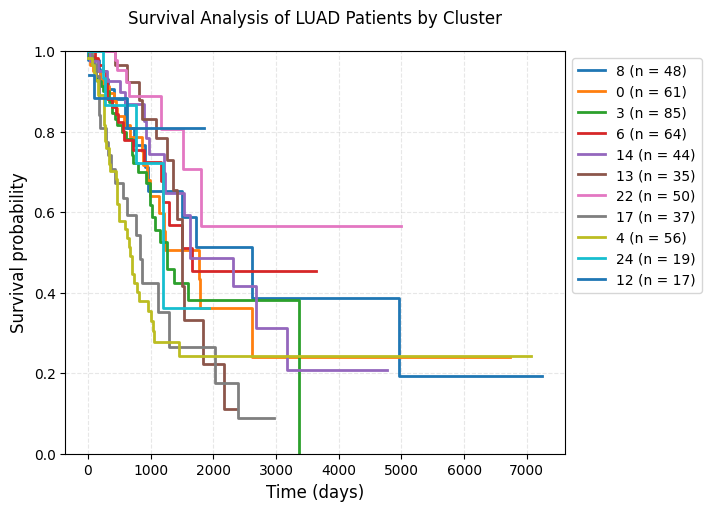

In [23]:
# Generate Kaplan-Meier survival analysis plot on LUAD clusters

dt = np.dtype([("status", bool), ("survival_in_days", np.float64)])
survival = []

for patient in nodes["patient"]:
    if ((np.isnan(meta.loc[patient,"tcga.gdc_cases.diagnoses.days_to_death"])) == False):
        days = meta.loc[patient,"tcga.gdc_cases.diagnoses.days_to_death"]
        status = True
    else:
        days = meta.loc[patient,"tcga.gdc_cases.diagnoses.days_to_last_follow_up"]
        status = False
    if ((np.isnan(days)) == True) or (days < 0): 
        days = 0
        status = False
    survival.append((status, days))
    
survival = np.array(survival, dtype = dt)

fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)

for cluster in nodes["cluster"].unique():
    mask = nodes["cluster"] == cluster
    time_cell, survival_prob_cell, conf_int = kaplan_meier_estimator(
        survival["status"][mask], survival["survival_in_days"][mask], conf_type="log-log"
    )
    ax.step(time_cell, survival_prob_cell, where="post", label=f"{cluster} (n = {mask.sum()})", linewidth=2)
    #plt.fill_between(time_cell, conf_int[0], conf_int[1], alpha=0.25, step="post")

ax.set_ylim(0, 1)
ax.set_ylabel("Survival probability", fontsize=12)
ax.set_xlabel("Time (days)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=True, fancybox=True, framealpha=0.8)

ax.set_title("Survival Analysis of LUAD Patients by Cluster", pad=20)
plt.savefig("LUAD-survival-analysis.png")
plt.show()

In [24]:
# Log-rank hypothesis test to test for statistically significant difference in LUAD cluster survival results
cluster_groups = nodes.loc[:, 'cluster']
groups = cluster_groups.unique()

chi2, pvalue = compare_survival(survival, cluster_groups)

print(pvalue)

8.891723342758056e-06


## Useful Cypher queries

In [ ]:
# Lists all graph projections in database
gds.graph.list()

In [286]:
# Deletes graph projection from database
gds.graph.drop("<graphName>")

In [321]:
# Gives number of nodes for each indication present in database
gds.run_cypher("""
    MATCH (n)
    RETURN labels(n)[0] AS study, COUNT(n) AS `number of nodes`
"""
)

,study,number of nodes
0,ACC,79
1,BLCA,408
2,BRCA,1093
3,CESC,304
4,CHOL,36
5,COAD,458
6,DLBC,48
7,ESCA,184
8,GBM,155
9,HNSC,502
